In [30]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from tqdm import tqdm

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

ImportError: No module named plotting

#### Load problem specific starter code

In [2]:
cd 'cs228/pa3'

/Users/lmcintosh/code/ipython-notebooks/classes/cs228/pa3


In [3]:
ls

cluster_graph.py  do_pa3.py         factors.py        images.mat        ldpc36-128.mat    ldpc36-1600.mat   old/


In [4]:
import do_pa3

Doing part (a): Should see 0.0, 0.0, >0.0
(0.0, 0.0, 0.77378093749999988)
Doing part (c)


In [5]:
def test_channel_noise():
    p_test = [0.01, 0.05, 0.1, 0.5, 1.0]
    y = np.round(np.random.rand(100,20)).astype('int')
    fraction_flipped = []
    for p in p_test:
        yhat = do_pa3.applyChannelNoise(y, p)
        fraction_flipped.append(np.sum(abs(yhat - y))/(1.0*np.prod(y.shape)))
    for idp, p in enumerate(p_test):
        print('Actual p = %0.2f, empirical p = %0.2f' %(p, fraction_flipped[idp]))
#     print(fraction_flipped)
#     print(p_test)
#     return np.mean(np.array(p_test) - np.array(fraction_flipped))

In [6]:
test_channel_noise()

Actual p = 0.01, empirical p = 0.01
Actual p = 0.05, empirical p = 0.06
Actual p = 0.10, empirical p = 0.10
Actual p = 0.50, empirical p = 0.51
Actual p = 1.00, empirical p = 1.00


# Part (a)

In [7]:
do_pa3.do_part_a()

(0.0, 0.0, 0.77378093749999988)


# Part (b)

Implemented loopy BP

# Part (c)

In [8]:
from do_pa3 import *
from factors import *
from cluster_graph import *

(-5, 5)

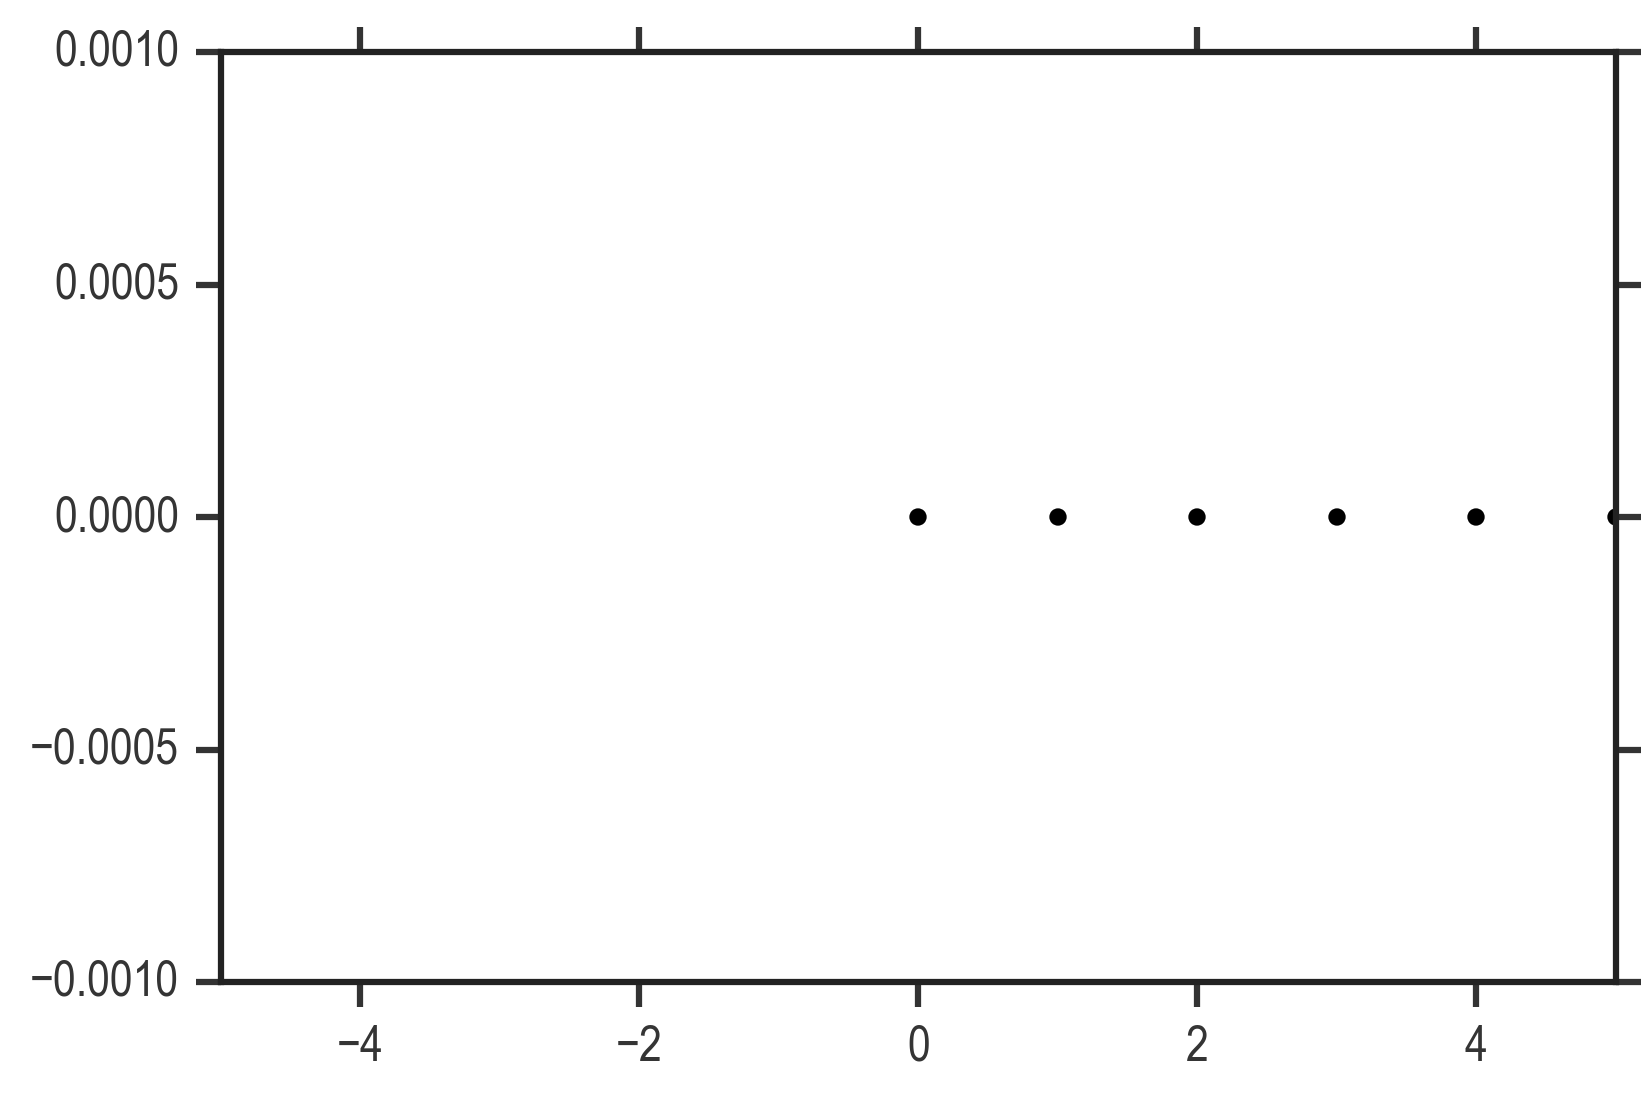

In [24]:
G, H = loadLDPC('ldpc36-128.mat')
p = 0.05
N = G.shape[1]
x = np.zeros((N, 1), dtype='int32')
y = encodeMessage(x, G)
##############################################################
# To do: your code starts here

# apply noise on y
yhat = applyChannelNoise(y, p)

# initialize graph
Graph = constructClusterGraph(yhat, H, p)

# initialize varToCliques
neighbor_vars = [f.scope for f in Graph.factor]
for var_i in range(len(Graph.varToCliques)):
    for fac_j,neighbors in enumerate(neighbor_vars):
        if var_i in neighbors:
            Graph.varToCliques[var_i].append(fac_j)

Graph.sepset = [[[] for j in xrange(len(Graph.factor))]
                for i in xrange(len(Graph.factor))]

# initialize nbr and sepset
for i in range(H.shape[0]):
    for j in range(H.shape[1]):
        if H[i][j]:
            Graph.nbr[i].append(H.shape[0] + j)
            Graph.nbr[H.shape[0] + j].append(i)
            Graph.sepset[i][H.shape[0] + j].append(j)
            Graph.sepset[H.shape[0] + j][i].append(j)

# initialize messages
Graph.messages = [[None for dst in range(len(Graph.factor))]
                    for src in range(len(Graph.factor))]
for src in range(len(Graph.factor)):
    for dst in Graph.nbr[src]:
        this_scope = Graph.sepset[src][dst]
        this_card = [2]*len(this_scope)
        Graph.messages[src][dst] = Factor(scope=this_scope,
                                        card=this_card,
                                        val=np.tile(1.0, this_card))



iterations = 50
Graph.runParallelLoopyBP(iterations)

# collect probabilities that bits = 1
marginals = [Graph.estimateMarginalProbability(i)[1] for i in range(len(yhat))]

#import pdb
#pdb.set_trace()

# plot it
plt.scatter(range(len(yhat)), marginals, s=10, color='k')
plt.xlim(-5, 5)

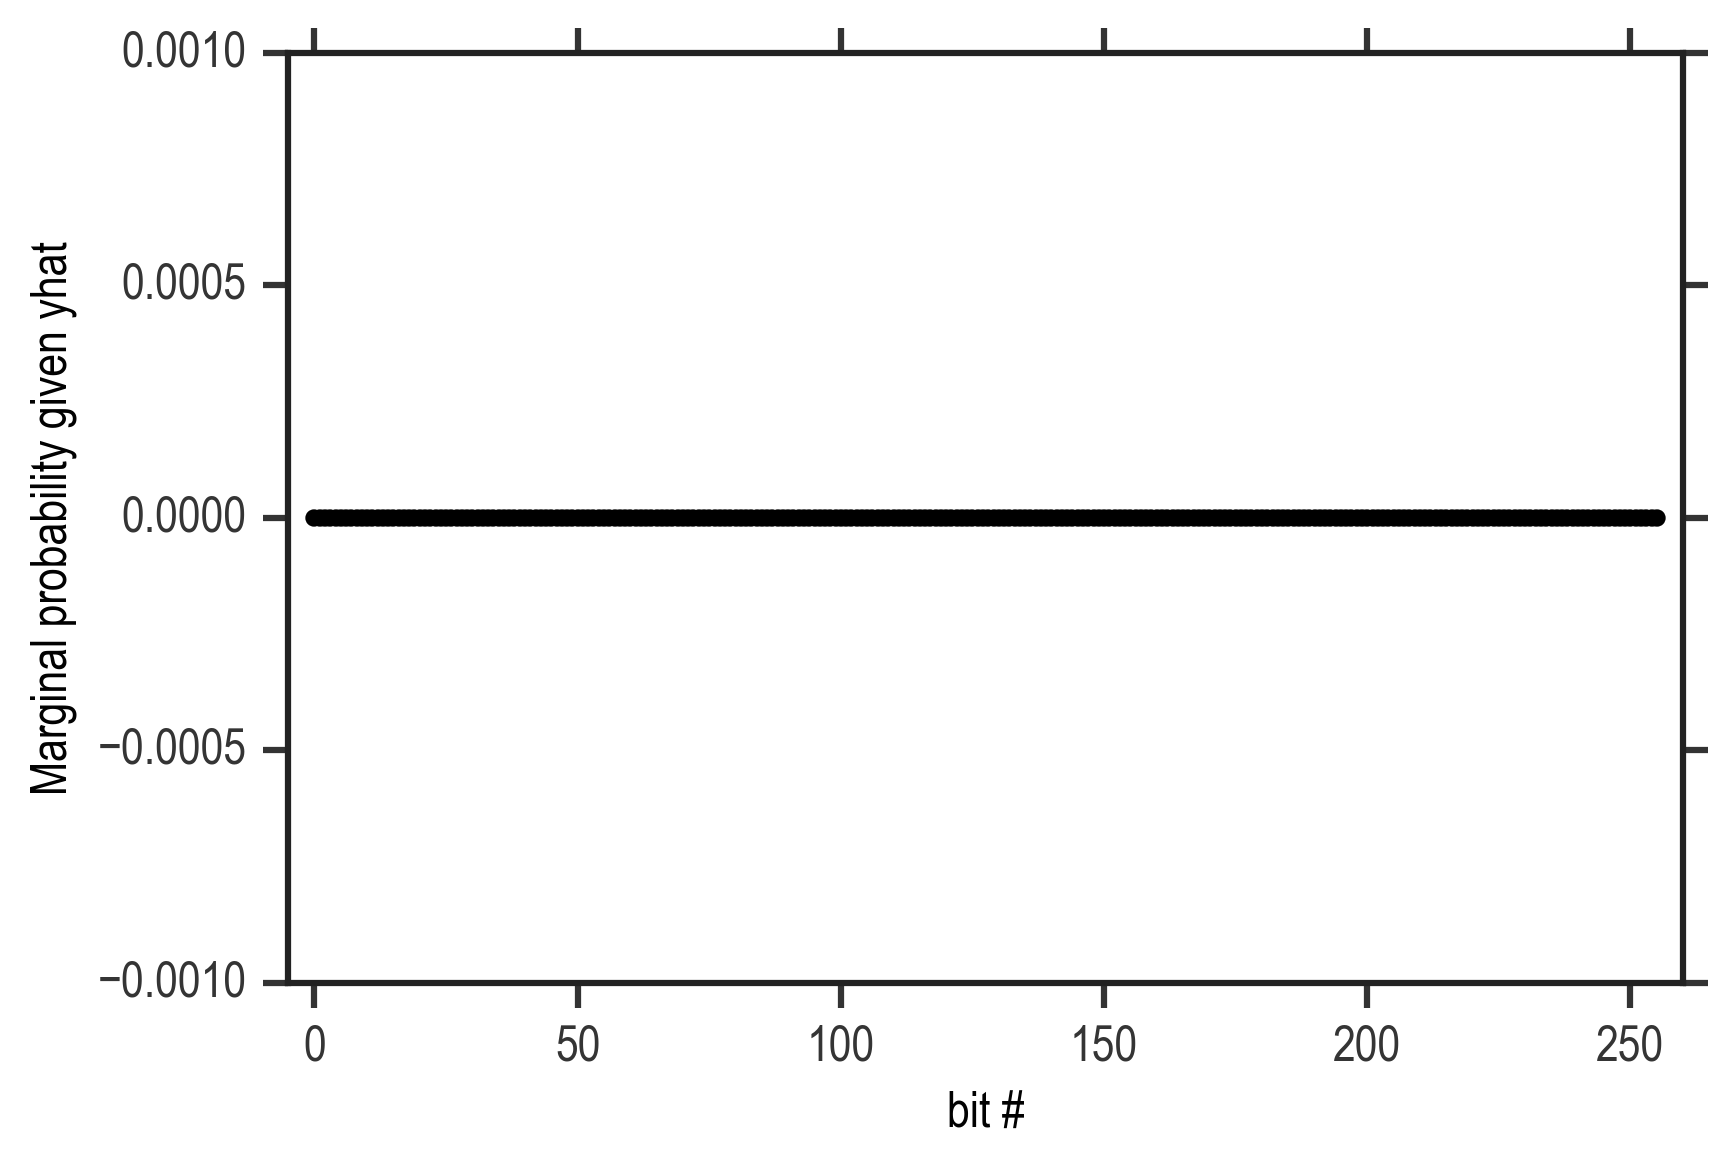

In [31]:
plt.scatter(range(len(yhat)), marginals, s=10, color='k')
plt.xlim(-5, 260)
plt.ylabel('Marginal probability given yhat')
plt.xlabel('bit #')

# Part (d) and (e)

In [40]:
ntrials = 10
iterations = 50

# dictionary of (ntrial, epsilon) hamming distances
all_hamming_distances = collections.defaultdict(list)


G, H = loadLDPC('ldpc36-128.mat')
N = G.shape[1]

for epsilon in [0.06, 0.08, 0.10]:
    p = epsilon
    
    for n in tqdm(range(ntrials)):
        
        x = np.zeros((N, 1), dtype='int32')
        y = encodeMessage(x, G)
        
        # apply noise on y
        yhat = applyChannelNoise(y, p)

        # initialize graph
        Graph = constructClusterGraph(yhat, H, p)

        # initialize varToCliques
        neighbor_vars = [f.scope for f in Graph.factor]
        for var_i in range(len(Graph.varToCliques)):
            for fac_j,neighbors in enumerate(neighbor_vars):
                if var_i in neighbors:
                    Graph.varToCliques[var_i].append(fac_j)

        Graph.sepset = [[[] for j in xrange(len(Graph.factor))]
                        for i in xrange(len(Graph.factor))]

        # initialize nbr and sepset
        for i in range(H.shape[0]):
            for j in range(H.shape[1]):
                if H[i][j]:
                    Graph.nbr[i].append(H.shape[0] + j)
                    Graph.nbr[H.shape[0] + j].append(i)
                    Graph.sepset[i][H.shape[0] + j].append(j)
                    Graph.sepset[H.shape[0] + j][i].append(j)

        # initialize messages
        Graph.messages = [[None for dst in range(len(Graph.factor))]
                            for src in range(len(Graph.factor))]
        for src in range(len(Graph.factor)):
            for dst in Graph.nbr[src]:
                this_scope = Graph.sepset[src][dst]
                this_card = [2]*len(this_scope)
                Graph.messages[src][dst] = Factor(scope=this_scope,
                                                card=this_card,
                                                val=np.tile(1.0, this_card))

        hamming_distance = []
        for it in range(iterations):
            Graph.runParallelLoopyBP(1)

            # collect probabilities that bits = 1
            marginals = [Graph.estimateMarginalProbability(i)[1] for i in range(len(yhat))]
            
            # since x is all zeros, hamming distance is number of bits = 1
            errors = [1 for m in marginals if m > 0.5]
            hamming_distance.append(np.sum(errors))
            
        all_hamming_distances[(n, epsilon)] = hamming_distance

Doing part (a): Should see 0.0, 0.0, >0.0
(0.0, 0.0, 0.77378093749999988)
Doing part (c)


In [41]:
all_hamming_distances.keys()

[(4, 0.1),
 (1, 0.06),
 (0, 0.1),
 (8, 0.1),
 (5, 0.08),
 (7, 0.06),
 (6, 0.1),
 (5, 0.1),
 (2, 0.08),
 (4, 0.06),
 (1, 0.1),
 (2, 0.06),
 (9, 0.1),
 (8, 0.06),
 (7, 0.1),
 (3, 0.08),
 (6, 0.08),
 (5, 0.06),
 (8, 0.08),
 (3, 0.1),
 (0, 0.08),
 (2, 0.1),
 (9, 0.06),
 (0, 0.06),
 (7, 0.08),
 (9, 0.08),
 (1, 0.08),
 (4, 0.08),
 (3, 0.06),
 (6, 0.06)]

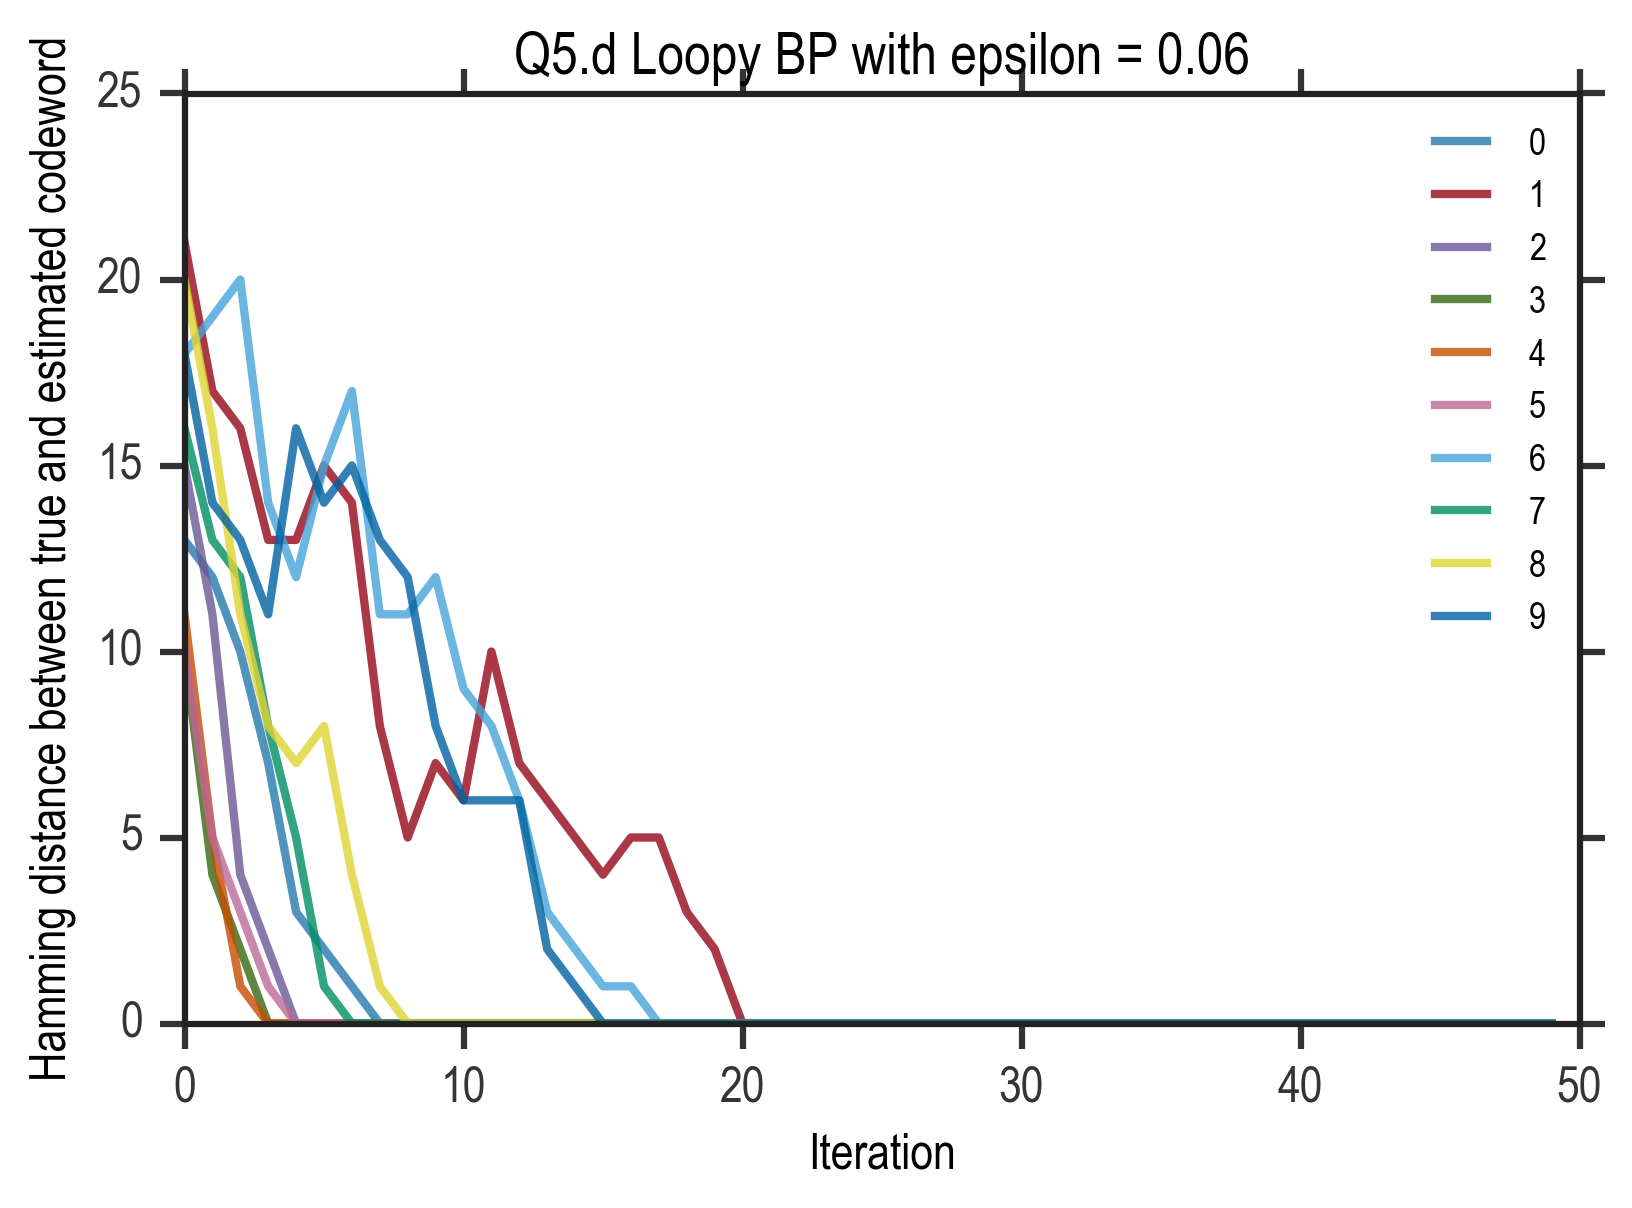

In [46]:
for trial, epsilon in sorted(all_hamming_distances.keys()):
    if epsilon == 0.06:
        these_distances = all_hamming_distances[(trial, epsilon)]
        plt.plot(np.arange(len(these_distances)), these_distances, label=trial, linewidth=2, alpha=0.8)

plt.legend(frameon=False, fontsize=9)
plt.xlabel('Iteration')
plt.ylabel('Hamming distance between true and estimated codeword')
plt.title('Q5.d Loopy BP with epsilon = 0.06', fontsize=14)

# (e)

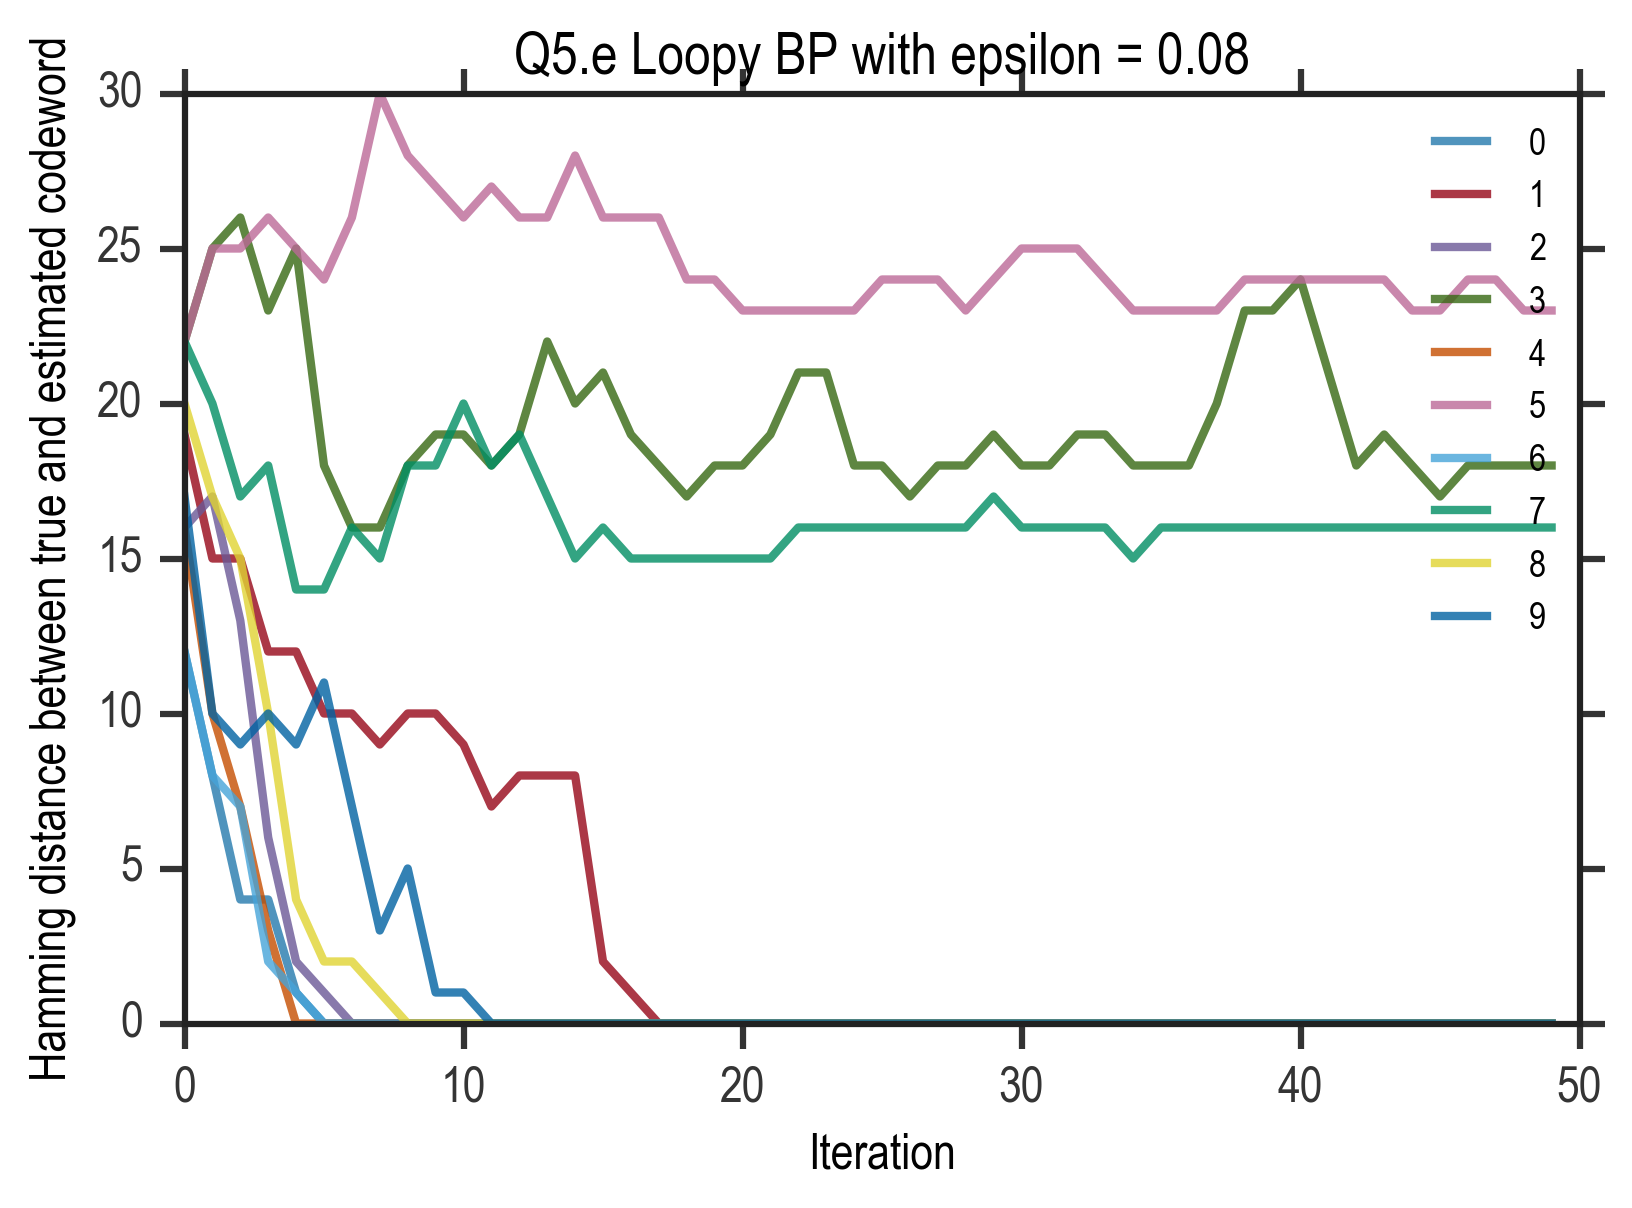

In [60]:
for trial, epsilon in sorted(all_hamming_distances.keys()):
    if epsilon == 0.08:
        these_distances = all_hamming_distances[(trial, epsilon)]
        plt.plot(np.arange(len(these_distances)), these_distances, label=trial, linewidth=2, alpha=0.8)

plt.legend(frameon=False, fontsize=9)
plt.xlabel('Iteration')
plt.ylabel('Hamming distance between true and estimated codeword')
plt.title('Q5.e Loopy BP with epsilon = 0.08', fontsize=14)

In [59]:
lasts = []
for trial, epsilon in sorted(all_hamming_distances.keys()):
    if epsilon == 0.08:
        these_distances = all_hamming_distances[(trial, epsilon)]
        lasts.append(these_distances[-1])

print('Mean Hamming distance after iteration 50 was %0.2f' %np.mean(lasts))

Mean Hamming distance after iteration 50 was 5.70


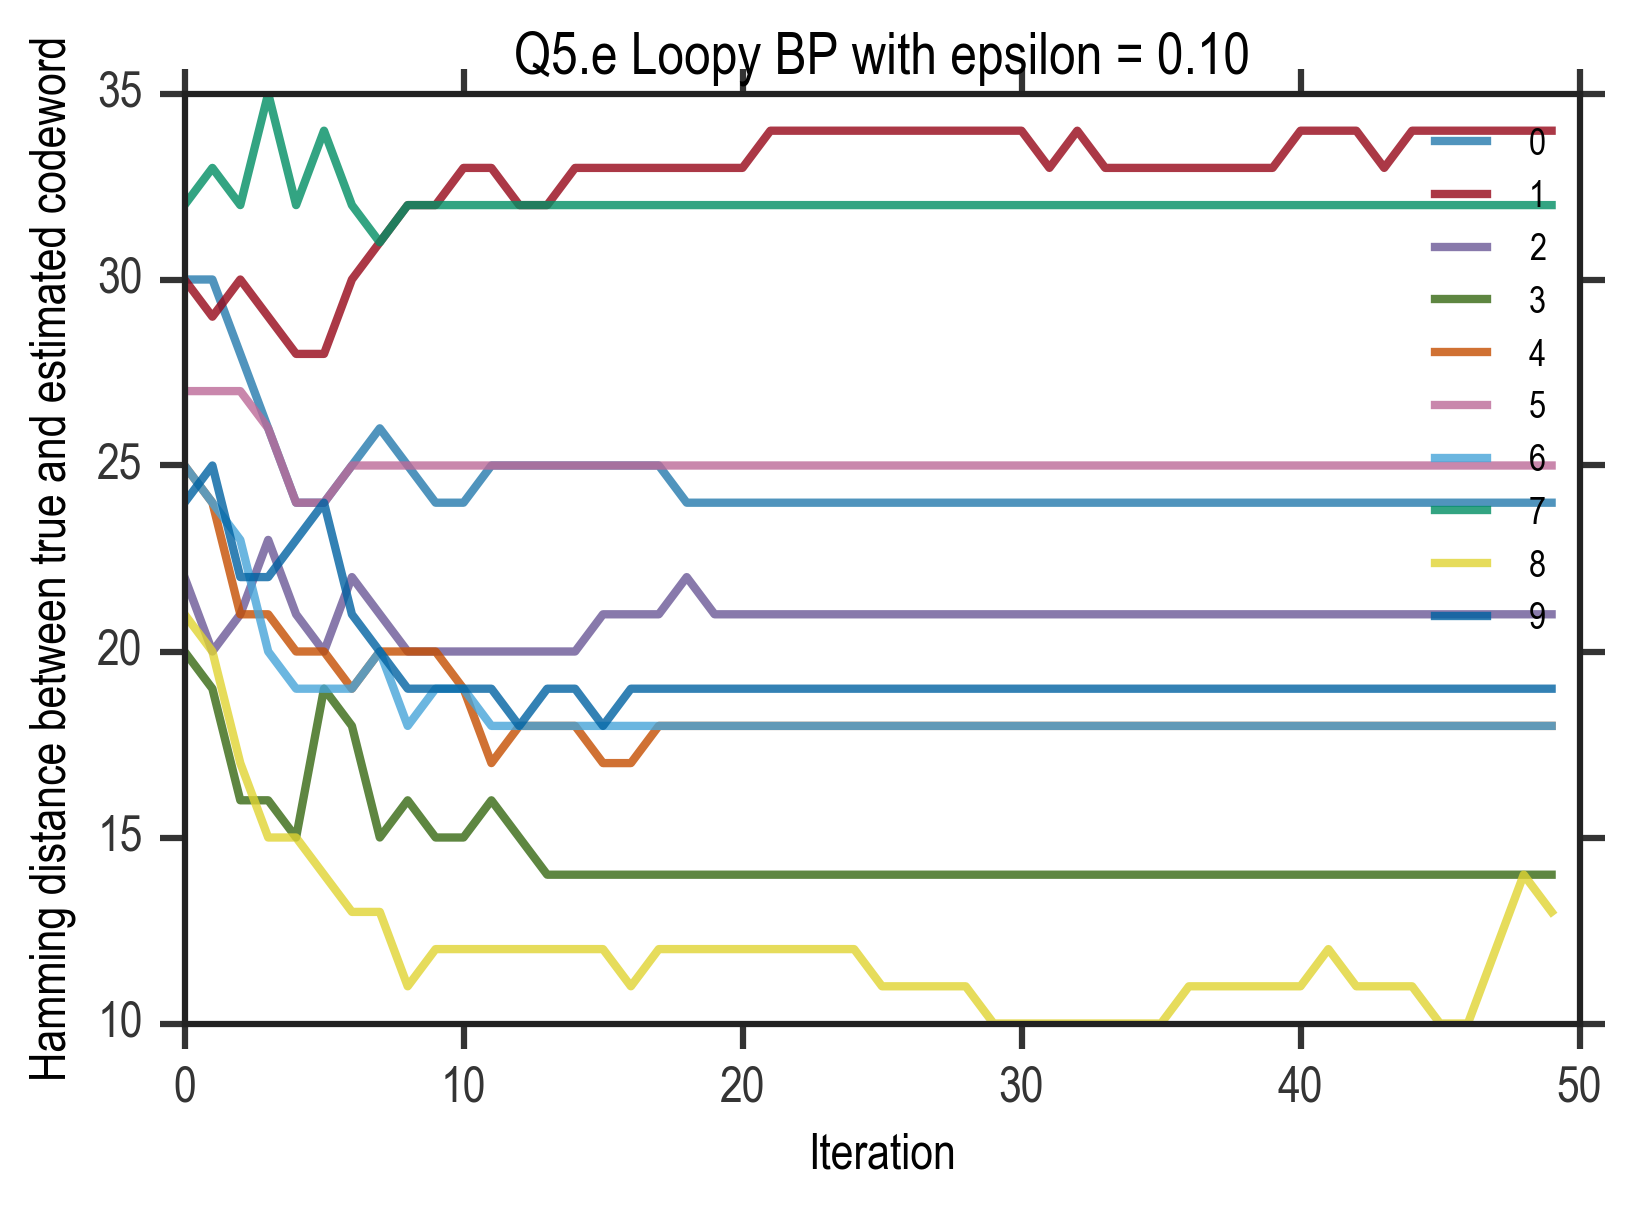

In [61]:
for trial, epsilon in sorted(all_hamming_distances.keys()):
    if epsilon == 0.10:
        these_distances = all_hamming_distances[(trial, epsilon)]
        plt.plot(np.arange(len(these_distances)), these_distances, label=trial, linewidth=2, alpha=0.8)

plt.legend(frameon=False, fontsize=9)
plt.xlabel('Iteration')
plt.ylabel('Hamming distance between true and estimated codeword')
plt.title('Q5.e Loopy BP with epsilon = 0.10', fontsize=14)

In [58]:
lasts = []
for trial, epsilon in sorted(all_hamming_distances.keys()):
    if epsilon == 0.10:
        these_distances = all_hamming_distances[(trial, epsilon)]
        lasts.append(these_distances[-1])

print('Mean Hamming distance after iteration 50 was %0.2f' %np.mean(lasts))

Mean Hamming distance after iteration 50 was 21.80


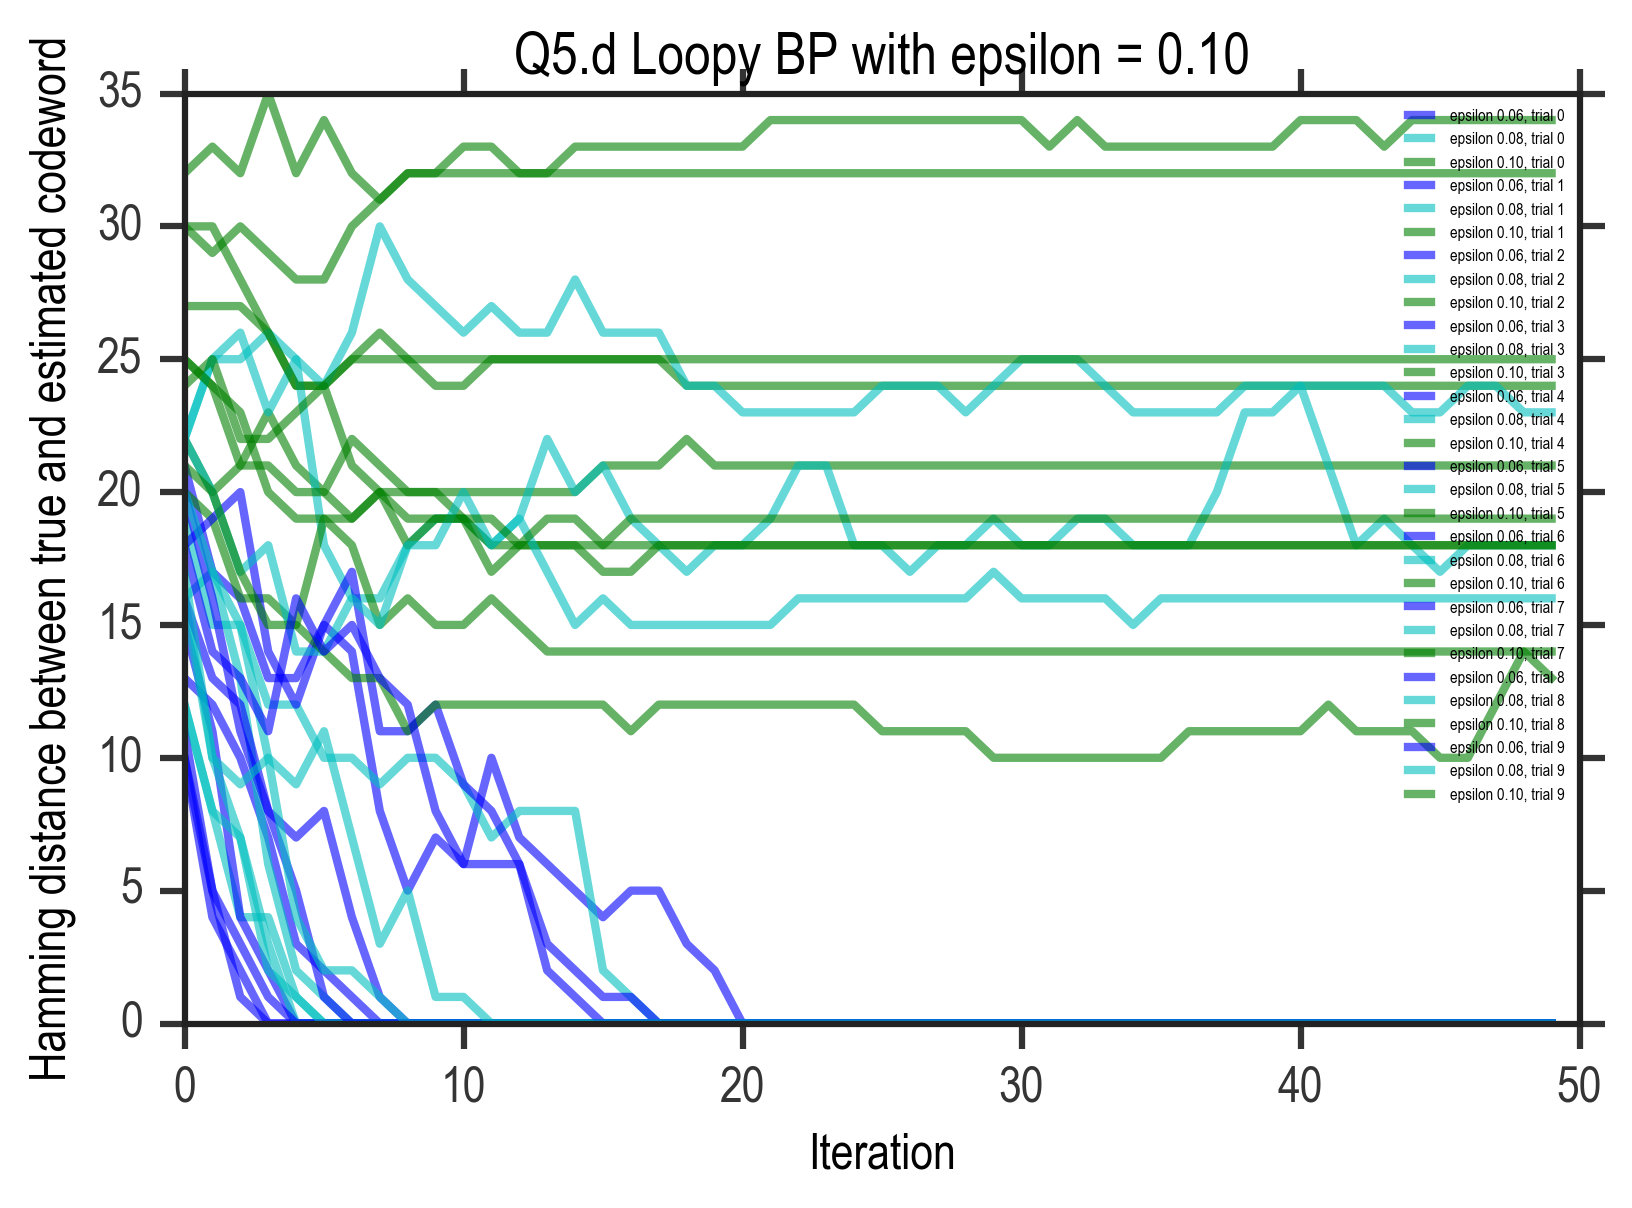

In [56]:
colorscheme = {0.10: 'g', 0.08: 'c', 0.06: 'b'}

for trial, epsilon in sorted(all_hamming_distances.keys()):
#     if epsilon == 0.10:
    these_distances = all_hamming_distances[(trial, epsilon)]
    plt.plot(np.arange(len(these_distances)), these_distances, label='epsilon %0.2f, trial %d' %(epsilon,trial),
             linewidth=2, alpha=0.6, color=colorscheme[epsilon])

plt.legend(frameon=False, fontsize=4)
plt.xlabel('Iteration')
plt.ylabel('Hamming distance between true and estimated codeword')
plt.title('Q5.d Loopy BP with epsilon = 0.10', fontsize=14)

# Parts (f) and (g)

In [76]:
G, H = loadLDPC('ldpc36-1600.mat')
img = loadImage('images.mat', 'cs242')
x = img.flatten()
y = encodeMessage(x, G)

iterations = 30
saved_iterations = [1, 2, 3, 5, 10, 20, 30]
# keys are (epsilon, iteration)
saved_images = collections.defaultdict(list)

for epsilon in [0.06, 0.10]:
    p = epsilon
    
    # apply noise on y
    yhat = applyChannelNoise(y, p)
    saved_images[(epsilon, 0)] = yhat
        
    # initialize graph
    Graph = constructClusterGraph(yhat, H, p)

    # initialize varToCliques
    neighbor_vars = [f.scope for f in Graph.factor]
    for var_i in range(len(Graph.varToCliques)):
        for fac_j,neighbors in enumerate(neighbor_vars):
            if var_i in neighbors:
                Graph.varToCliques[var_i].append(fac_j)

    Graph.sepset = [[[] for j in xrange(len(Graph.factor))]
                    for i in xrange(len(Graph.factor))]

    # initialize nbr and sepset
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            if H[i][j]:
                Graph.nbr[i].append(H.shape[0] + j)
                Graph.nbr[H.shape[0] + j].append(i)
                Graph.sepset[i][H.shape[0] + j].append(j)
                Graph.sepset[H.shape[0] + j][i].append(j)

    # initialize messages
    Graph.messages = [[None for dst in range(len(Graph.factor))]
                        for src in range(len(Graph.factor))]
    for src in range(len(Graph.factor)):
        for dst in Graph.nbr[src]:
            this_scope = Graph.sepset[src][dst]
            this_card = [2]*len(this_scope)
            Graph.messages[src][dst] = Factor(scope=this_scope,
                                            card=this_card,
                                            val=np.tile(1.0, this_card))

    hamming_distance = []
    for it in tqdm(range(iterations)):
        Graph.runParallelLoopyBP(1)
        
        if (it+1) in saved_iterations:
            # collect probabilities that bits = 1
            marginals_1 = np.array([Graph.estimateMarginalProbability(i)[1] for i in range(len(yhat))])
            marginals_0 = np.array([Graph.estimateMarginalProbability(i)[0] for i in range(len(yhat))])
            decoded = np.where(marginals_1 > marginals_0, 1, 0)   
            saved_images[(epsilon, it+1)] = decoded[:1600]

In [79]:
len(saved_images.keys())

14

In [80]:
sorted(saved_images.keys())

[(0.06, 0),
 (0.06, 1),
 (0.06, 2),
 (0.06, 4),
 (0.06, 9),
 (0.06, 19),
 (0.06, 29),
 (0.1, 0),
 (0.1, 1),
 (0.1, 2),
 (0.1, 4),
 (0.1, 9),
 (0.1, 19),
 (0.1, 29)]

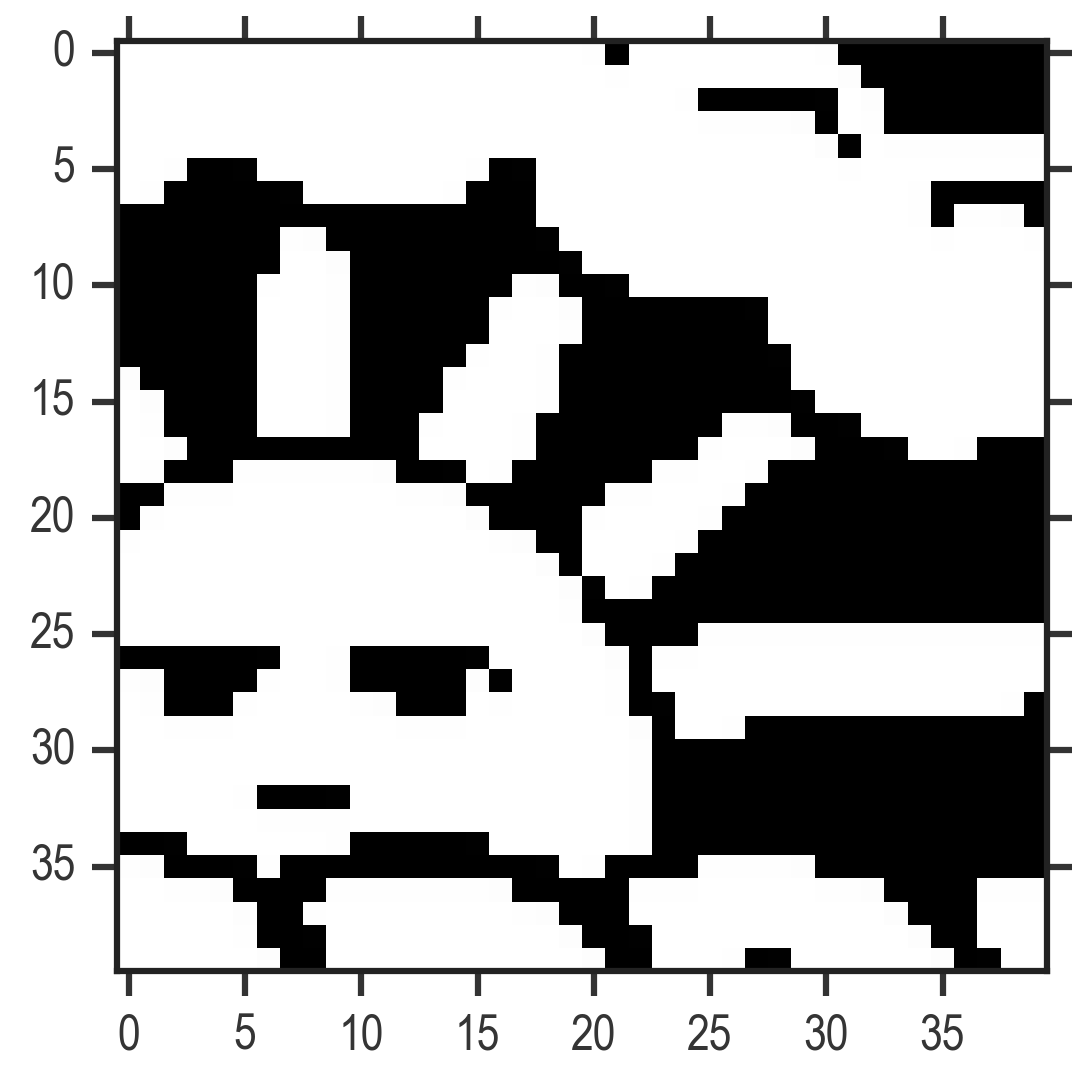

In [75]:
plt.imshow(saved_images[(0.06, 20)][:1600].reshape((40, 40)))

### Make a grid of images

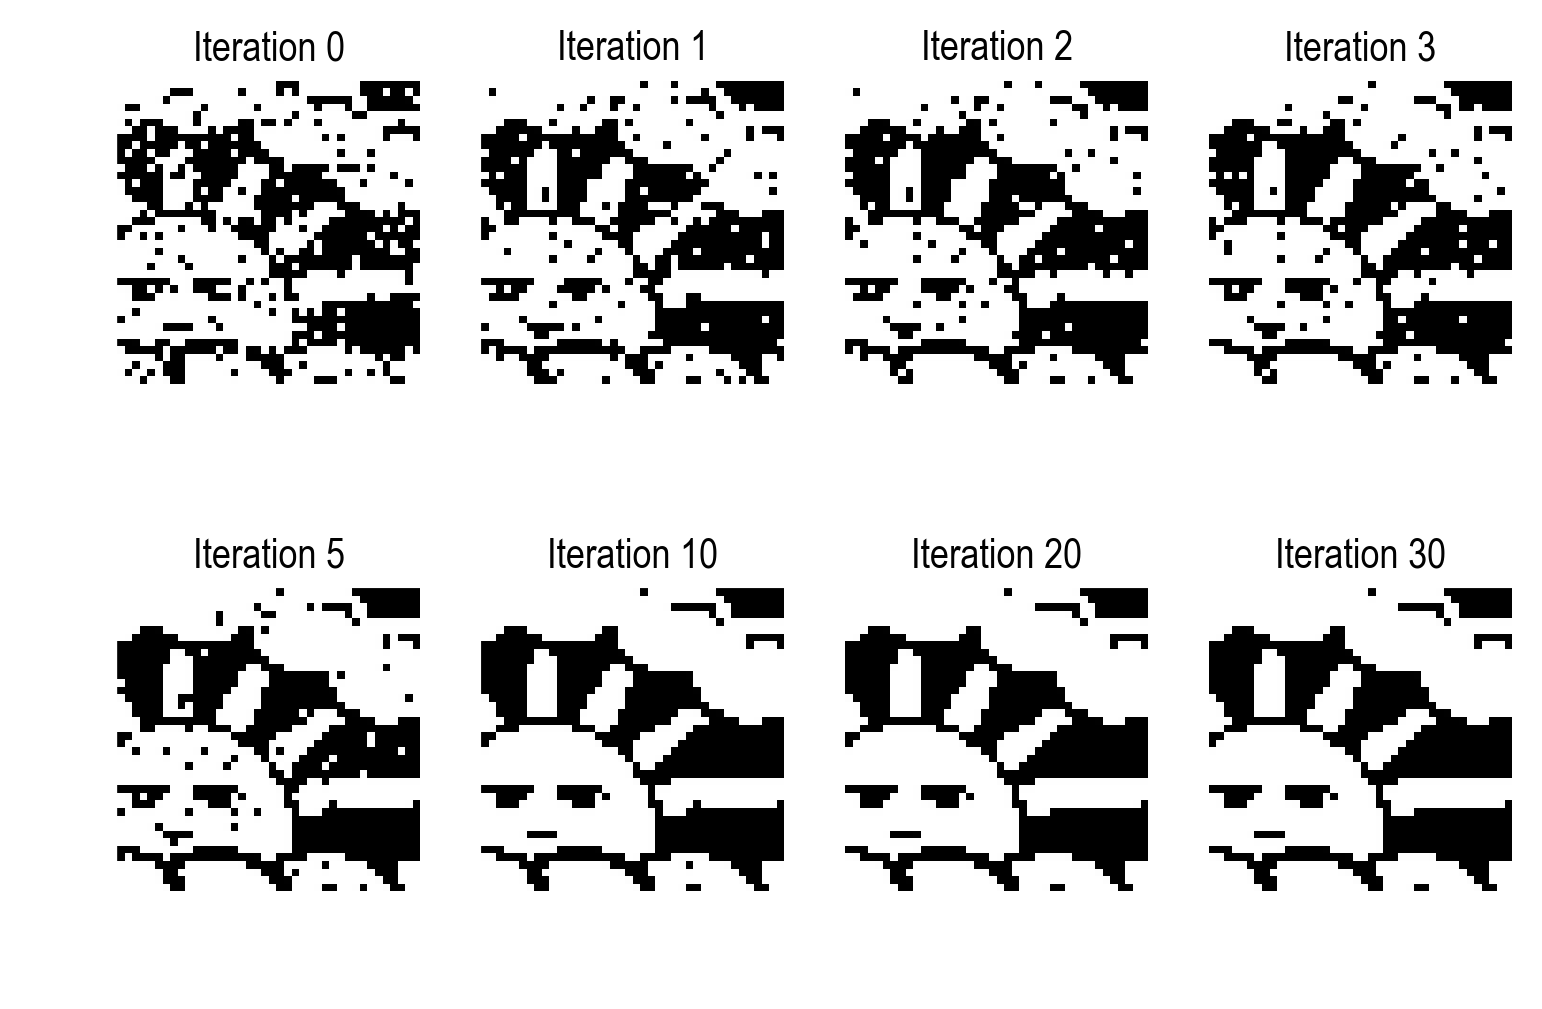

In [84]:
rows = 2
cols = 4
for idx,i in enumerate(saved_iterations):
    saved_i = i - 1
    
    if idx == 0:
        plt.subplot(rows, cols, idx+1)
        plt.imshow(yhat[:1600].reshape((40,40)))
        plt.title('Iteration 0', fontsize=10)
        plt.axis('off')
    
    plt.subplot(rows, cols, idx+2)
    plt.imshow(saved_images[(0.06, saved_i)].reshape((40,40)))
    plt.title('Iteration %d' %i, fontsize=10)
    plt.axis('off')

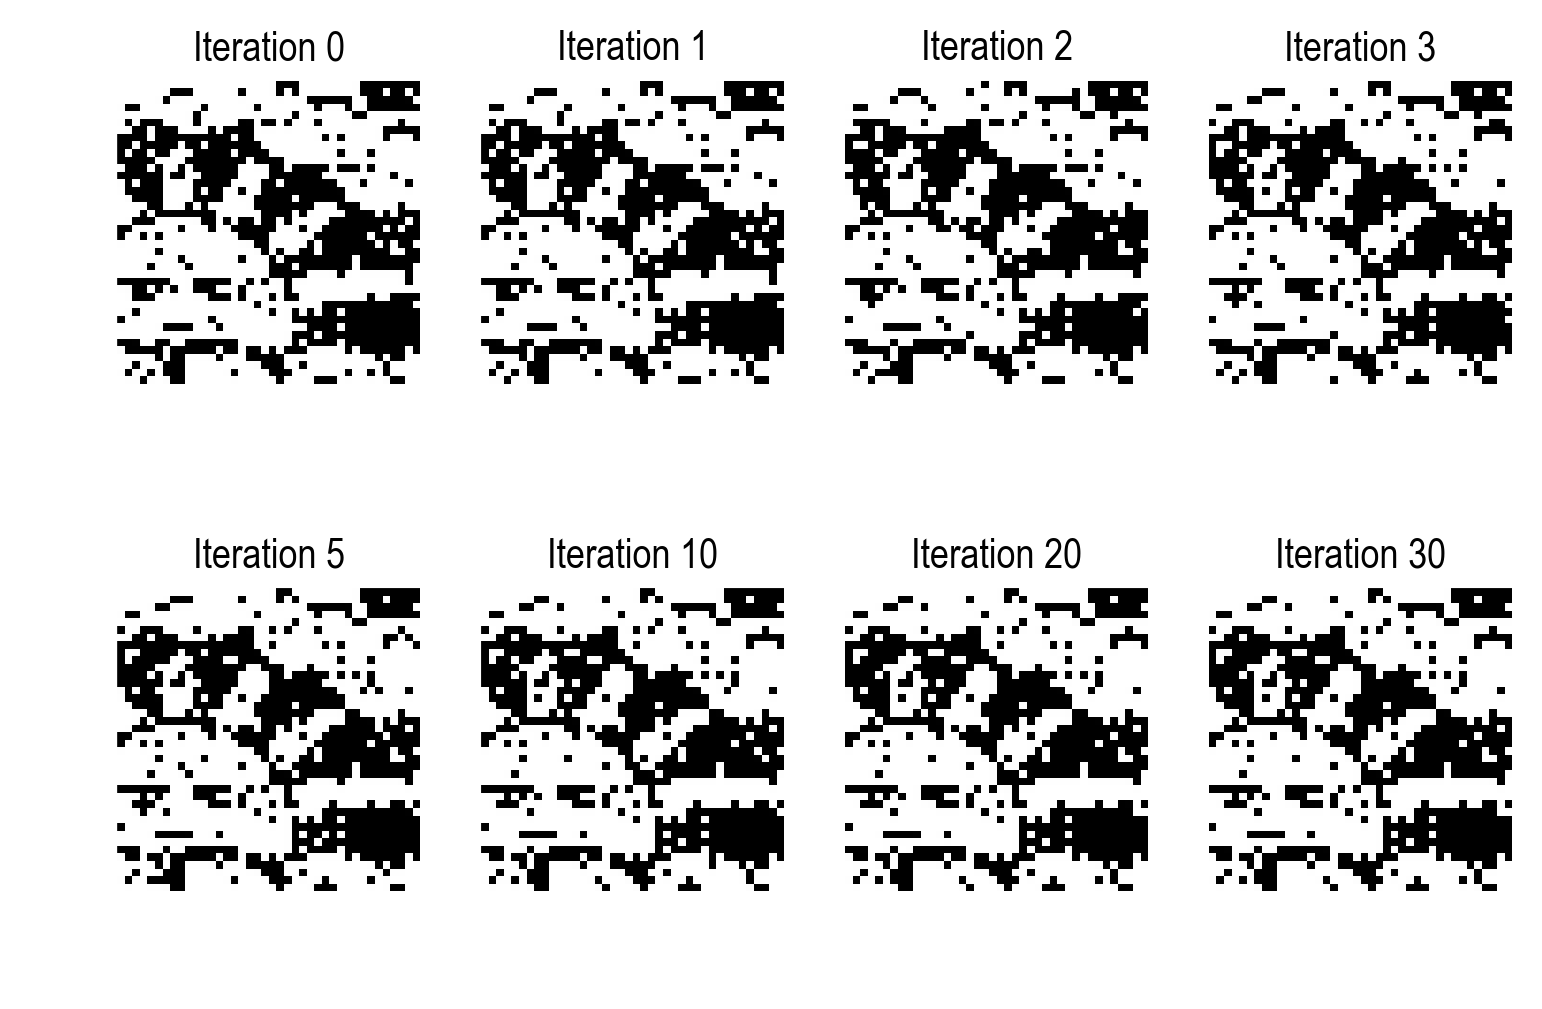

In [85]:
rows = 2
cols = 4
for idx,i in enumerate(saved_iterations):
    saved_i = i - 1
    
    if idx == 0:
        plt.subplot(rows, cols, idx+1)
        plt.imshow(yhat[:1600].reshape((40,40)))
        plt.title('Iteration 0', fontsize=10)
        plt.axis('off')
    
    plt.subplot(rows, cols, idx+2)
    plt.imshow(saved_images[(0.10, saved_i)].reshape((40,40)))
    plt.title('Iteration %d' %i, fontsize=10)
    plt.axis('off')

In [88]:
np.sum(abs(saved_images[(0.10, 29)] - y[:1600]))

168

In [89]:
np.sum(abs(saved_images[(0.06, 29)] - y[:1600]))

0